In [61]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, exposure, feature, filters, measure, morphology, io, transform, util
from lab_code import flir_image_extractor

# Set to True to run the notebook without waiting for user interaction
DISABLE_GUI = False


# Helper Functions

In [62]:
def visual_prep(filename, convert_to_grayscale=True, target_width = 1600):
    """
    Prepare an image for the lab: read it, optionally convert to grayscale, and
    downscale it to a target width.

    Args:
        filename (str): Path to the image file.
        convert_to_grayscale (bool, optional): Whether to convert to grayscale.
            Default: True.
        target_width (int, optional): Maximum width in pixels. Images wider than this
            are downscaled with aspect ratio preserved; narrower images keep their
            original size. Default: 1600.

    Returns:
        numpy.ndarray: The processed image as uint8.
    """

    image = io.imread(filename)
    if image.ndim == 3 and image.shape[2] == 4:
        image = color.rgba2rgb(image)
    if convert_to_grayscale and image.ndim == 3:
        image = color.rgb2gray(image)

    height, width = image.shape[:2]

    # Resize to target_width while preserving aspect ratio
    if width > target_width:
        scale = target_width / width
        new_height = int(round (height * scale))
        image = transform.resize(image, (new_height, target_width), anti_aliasing=True)

    image = util.img_as_ubyte(image)

    return image


def thermal_prep(filename):
    """
    Prepare a FLIR thermal image for the lab by reading it.

    Args:
        filename (str): Path to the FLIR thermal image file.

    Returns:
        numpy.ndarray: The prepared thermal image as a 2D float array.
    """

    image_extractor = flir_image_extractor.FlirImageExtractor()
    image_extractor.process_image(filename)
    thermal = image_extractor.extract_thermal_image()

    return thermal


def thermal_prep_uint8(filename, vmin=None, vmax=None, clip_percentiles=(2, 98)):
    """
    Prepare a FLIR thermal image for the lab by reading it and mapping its dynamic range
    to uint8.

    Args:
        filename (str): Path to the FLIR thermal image file.
        vmin/vmax (float, optional): Lower/upper raw thermal values to map to 0/255. If
            either is 'None', it is inferred from the specified 'clip_percentiles'.
            Default: None.
        clip_percentiles ((float, float), optional): Percentiles (low, high) in [0, 100]
            used to infer 'vmin'/'vmax' when not provided. Default: (2, 98).

    Returns:
        numpy.ndarray: The thermal image mapped to uint8.
    """

    thermal = thermal_prep(filename).astype(np.float32)

    # Auto-select vmin/vmax if not provided
    if vmin is None or vmax is None:
        lo, hi = np.percentile(thermal, clip_percentiles)
        vmin = lo if vmin is None else vmin
        vmax = hi if vmax is None else vmax

    scaled = (thermal - vmin) * (255.0 / max(1e-6, (vmax - vmin)))
    return np.clip(scaled, 0, 255).astype(np.uint8)


# Step 1 - Color Identification

In [63]:
import numpy as np
from skimage import color

def red_mask(img,
             hue_low1=0.00, hue_high1=0.04,
             hue_low2=0.96, hue_high2=1.00,
             sat_thresh=0.25,
             val_thresh=0.25):
    """
    Step 1: Red color threshold (hardware-friendly).

    Inputs:
        img - RGB image uint8
    Outputs:
        mask - binary mask (0/1 uint8)
    
    Logic:
        - Convert to HSV
        - Mark hue in the two red ranges
        - Require saturation >= threshold
        - Require value >= threshold
    """

    hsv = color.rgb2hsv(img.astype(np.float32) / 255.0)

    h = hsv[:, :, 0]
    s = hsv[:, :, 1]
    v = hsv[:, :, 2]

    # Red hue appears at the start and at the end of the hue circle
    hue_mask = ((h >= hue_low1) & (h <= hue_high1)) | \
               ((h >= hue_low2) & (h <= hue_high2))

    sat_mask = s >= sat_thresh
    val_mask = v >= val_thresh

    mask = (hue_mask & sat_mask & val_mask).astype(np.uint8)

    return mask


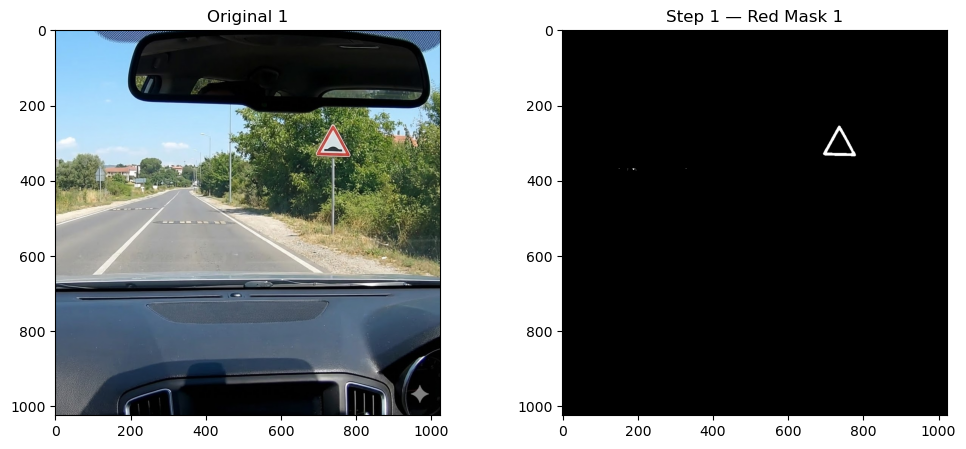

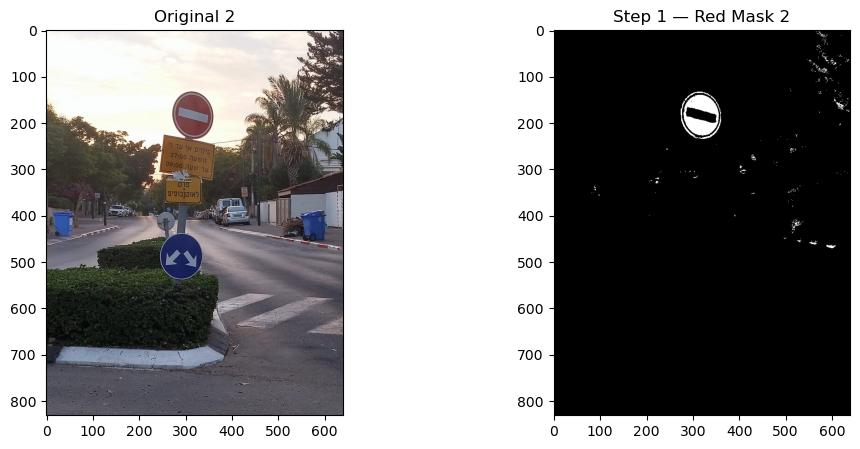

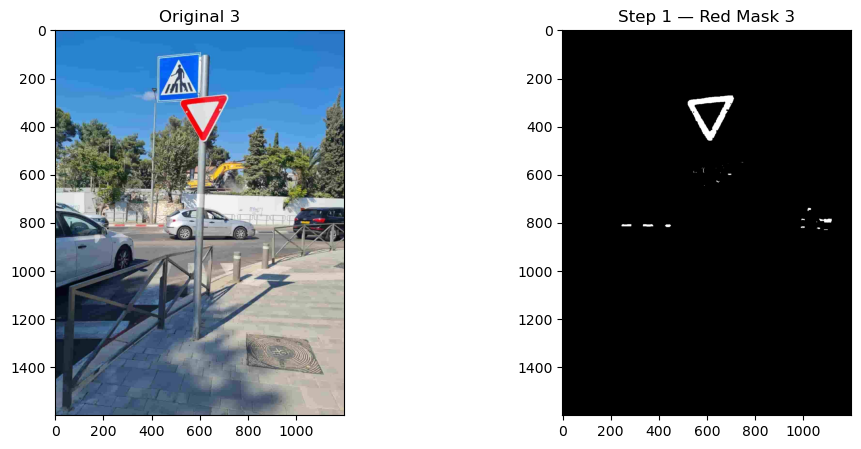

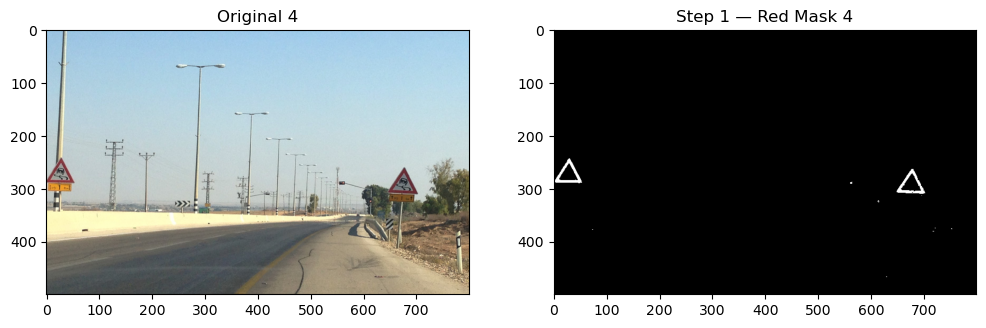

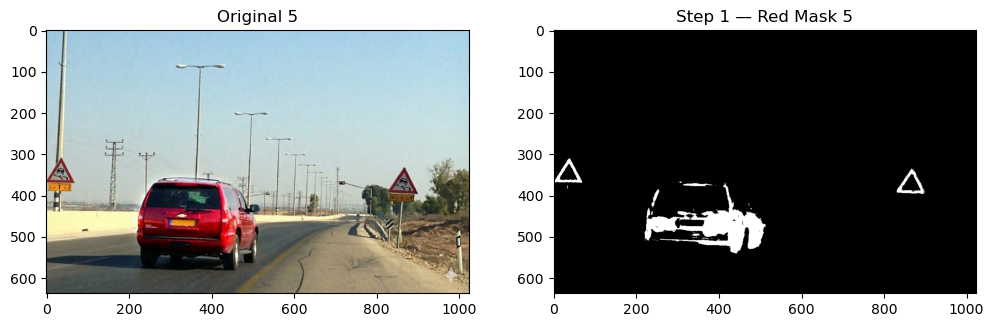

In [64]:
# Test Step 1
paths = [
    'real_pictures/bumpers.jpg',
    'real_pictures/No_enterance.jpg',
    'real_pictures/down_triangle.jpg',
    'real_pictures/slippery_road.jpg',
    'real_pictures/slippery_road_redcar.jpg'
]

images = [io.imread(p) for p in paths]
masks_step1 = [red_mask(img) for img in images]

for i, (img, m) in enumerate(zip(images, masks_step1), start=1):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Original {i}")

    plt.subplot(1, 2, 2)
    plt.imshow(m, cmap='gray')
    plt.title(f"Step 1 — Red Mask {i}")

    plt.show()


step 1.5 - Morphological cleaning

In [65]:
import numpy as np
from skimage import morphology, measure

def has_large_hole(mask, min_hole_size=300):
    """
    Detect whether the red mask contains a significant internal hole.
    A hole is a connected component of zeros inside the foreground.
    """
    # invert mask: holes become 1, background stays 0
    inv = 1 - mask

    # label all zero-regions
    labels = measure.label(inv, connectivity=1)
    props = measure.regionprops(labels)

    H, W = mask.shape

    for p in props:
        area = p.area
        # bounding box of the “hole”
        (minr, minc, maxr, maxc) = p.bbox
        print(f"Hole label={p.label}, area={area}, bbox={p.bbox}")
        # If the hole touches the border → it’s background, not a real hole
        if minr == 0 or minc == 0 or maxr == H or maxc == W:
            continue

        if area >= min_hole_size:
            return True
    
    return False


def fix_circle_gap(mask, radius=5):
    """
    Closing operation: dilation then erosion.
    Used only for circular signs that contain an internal hole.
    """
    strel = morphology.disk(radius)
    dil = morphology.dilation(mask, strel)
    clo = morphology.erosion(dil, strel)
    return clo


# ---------------------------
# New: fill enclosed holes & solidify mask (hardware-friendly)
# ---------------------------
def fill_enclosed_holes(mask, min_hole_size=10, min_foreground_size=None):
    """
    Fill holes that are completely enclosed by the foreground and then remove
    small foreground objects (noise).

    Returns: (filled_mask, hole_props, f_labels, f_props)
    - f_labels: labeled foreground after filling (skimage labeling)
    - f_props: list of regionprops for the labeled foreground
    """
    inv = 1 - mask
    labels = measure.label(inv, connectivity=1)
    props = measure.regionprops(labels)
    H, W = mask.shape
    filled = mask.copy().astype(np.uint8)

    hole_props = []
    for p in props:
        if p.area < min_hole_size:
            continue
        minr, minc, maxr, maxc = p.bbox
        # if hole touches border -> skip (not enclosed)
        if minr == 0 or minc == 0 or maxr == H or maxc == W:
            continue
        # fill this hole
        filled[labels == p.label] = 1
        hole_props.append({"label": p.label, "area": p.area, "bbox": p.bbox})

    # Remove small foreground components (noise) AFTER filling holes so we don't need
    # a separate global remove_noise pass later.
    if min_foreground_size is None:
        min_foreground_size = min_hole_size

    f_labels = measure.label(filled, connectivity=1)
    f_props = measure.regionprops(f_labels)
    for p in f_props:
        if p.area < min_foreground_size:
            filled[f_labels == p.label] = 0

    # Recompute labels/props after removing small foreground components to reflect final state
    f_labels = measure.label(filled, connectivity=1)
    f_props = measure.regionprops(f_labels)

    return filled, hole_props, f_labels, f_props

def solidify_mask(mask, close_radius=5, min_hole_size=10, smooth_radius=0, min_foreground_size=None):
    """
    Make hollow shapes solid:
      1) small morphological closing to close thin gaps,
      2) fill enclosed holes via connected components (and remove small foreground objects),
      3) optional additional closing/dilation for smoothing.
    Returns: (filled_mask, hole_props, f_labels, f_props).
    """
    st = morphology.disk(close_radius)
    closed = morphology.erosion(morphology.dilation(mask, st), st)  # closing

    # fill holes and also remove small foreground components inside that routine
    filled, hole_props, f_labels, f_props = fill_enclosed_holes(closed, min_hole_size=min_hole_size,
                                                                 min_foreground_size=min_foreground_size)

    if smooth_radius and smooth_radius > 0:
        st2 = morphology.disk(smooth_radius)
        filled = morphology.erosion(morphology.dilation(filled, st2), st2)
        # update labels/props after smoothing
        f_labels = measure.label(filled, connectivity=1)
        f_props = measure.regionprops(f_labels)

    return filled, hole_props, f_labels, f_props


# Step 2 - Shape Classification

Hole label=1, area=1044625.0, bbox=(0, 0, 1024, 1024)
Hole label=2, area=2091.0, bbox=(267, 705, 328, 771)
Image 1: Large hole detected → applying Closing


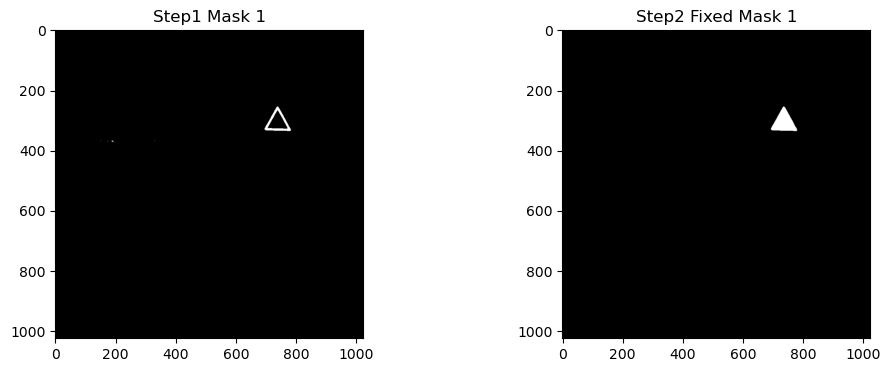

Hole label=1, area=524580.0, bbox=(0, 0, 831, 640)
Hole label=2, area=1.0, bbox=(62, 585, 63, 586)
Hole label=3, area=1.0, bbox=(84, 584, 85, 585)
Hole label=4, area=1.0, bbox=(85, 585, 86, 586)
Hole label=5, area=1.0, bbox=(87, 584, 88, 585)
Hole label=6, area=1.0, bbox=(90, 582, 91, 583)
Hole label=7, area=1.0, bbox=(131, 606, 132, 607)
Hole label=8, area=1.0, bbox=(140, 293, 141, 294)
Hole label=9, area=2.0, bbox=(153, 296, 155, 297)
Hole label=10, area=1.0, bbox=(159, 614, 160, 615)
Hole label=11, area=1.0, bbox=(161, 614, 162, 615)
Hole label=12, area=5.0, bbox=(162, 615, 164, 619)
Hole label=13, area=1.0, bbox=(163, 613, 164, 614)
Hole label=14, area=2.0, bbox=(164, 616, 166, 617)
Hole label=15, area=3.0, bbox=(165, 618, 167, 620)
Hole label=16, area=1294.0, bbox=(166, 284, 201, 350)
Image 2: Large hole detected → applying Closing


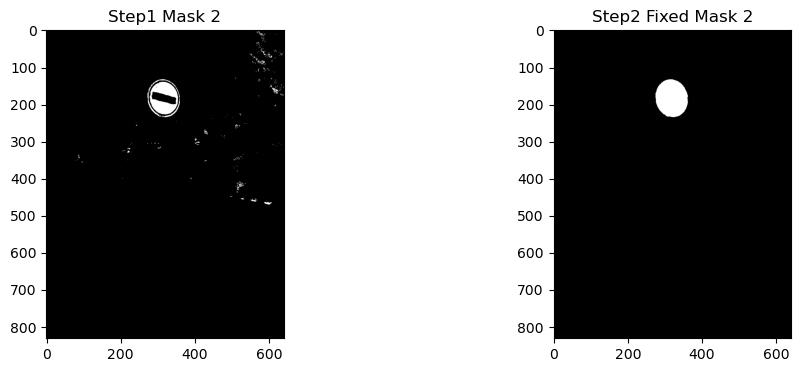

Hole label=1, area=1897390.0, bbox=(0, 0, 1600, 1200)
Hole label=2, area=8163.0, bbox=(298, 551, 421, 678)
Image 3: Large hole detected → applying Closing


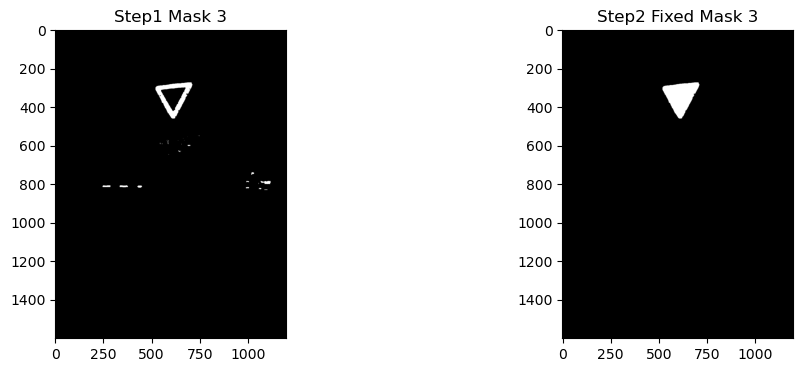

Hole label=1, area=397277.0, bbox=(0, 0, 500, 800)
Hole label=2, area=608.0, bbox=(254, 10, 285, 45)
Image 4: Large hole detected → applying Closing


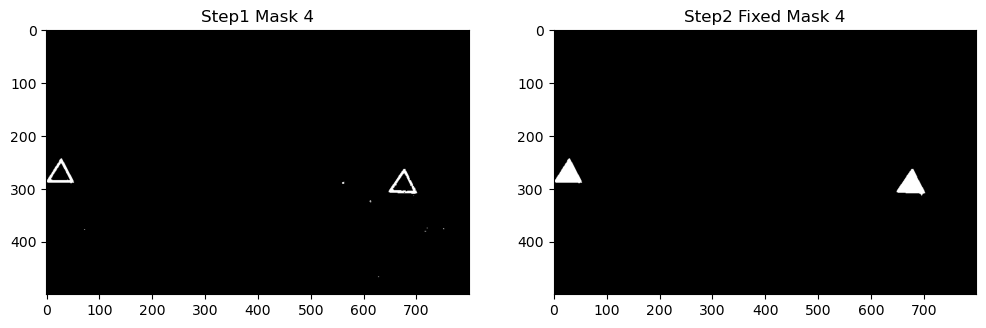

Hole label=1, area=630103.0, bbox=(0, 0, 637, 1024)
Hole label=2, area=929.0, bbox=(324, 14, 363, 56)
Image 5: Large hole detected → applying Closing


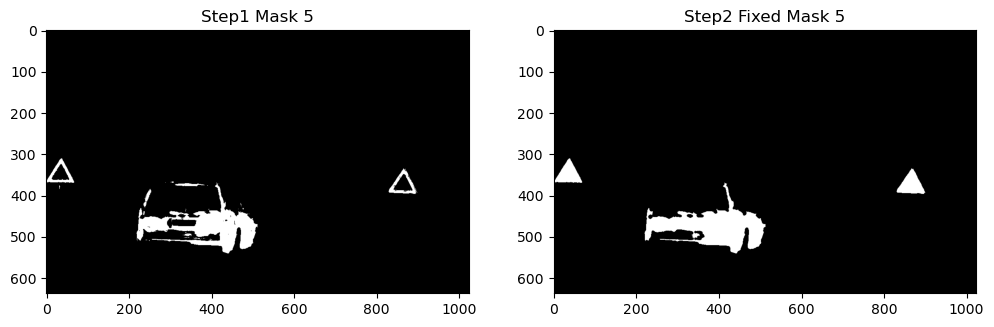

In [66]:
fixed_masks = []
fixed_labels_list = []
fixed_props_list = []
obj_properties = []

for i, m in enumerate(masks_step1, start=1):

    if has_large_hole(m, min_hole_size=300):
        print(f"Image {i}: Large hole detected → applying Closing")
        m_fixed, hole_props, f_labels, f_props = solidify_mask(m, close_radius=3, min_hole_size=300, smooth_radius=0, min_foreground_size=1000)
    else:
        print(f"Image {i}: No hole → keeping mask as is")
        # still run solidify_mask to ensure consistent labeling/cleaning
        m_fixed, hole_props, f_labels, f_props = solidify_mask(m, close_radius=3, min_hole_size=300, smooth_radius=0, min_foreground_size=1000)

    fixed_masks.append(m_fixed)
    fixed_labels_list.append(f_labels)
    fixed_props_list.append(f_props)
    obj_properties.append(hole_props)

    # Visualization
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(m, cmap='gray')
    plt.title(f"Step1 Mask {i}")

    plt.subplot(1,2,2)
    plt.imshow(m_fixed, cmap='gray')
    plt.title(f"Step2 Fixed Mask {i}")
    plt.show()


In [67]:
# connected_components_lowlevel is deprecated — replaced by skimage.measure.label + regionprops
def connected_components_lowlevel(mask):
    raise RuntimeError('connected_components_lowlevel is deprecated; use labels/props returned by solidify_mask')


# Step 2.5  - Shape Filtering + Debug Visualization


 IMAGE 1 — Step 4 Shape Filtering
Total components found: 1


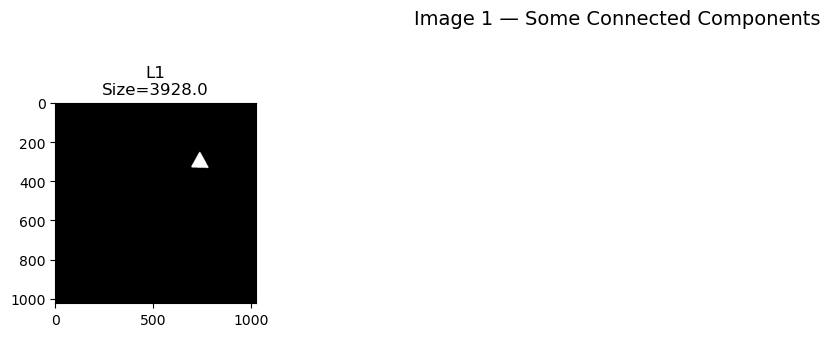


Component 1:
  Size        = 3928.0
  Area        = 3928.0
  Perimeter   = 282.1076477383248
  Circularity = 0.620
  → accepted (triangle)

SELECTED COMPONENT:
  Size   = 3928.0
  BBox   = (254, 694, 336, 782)



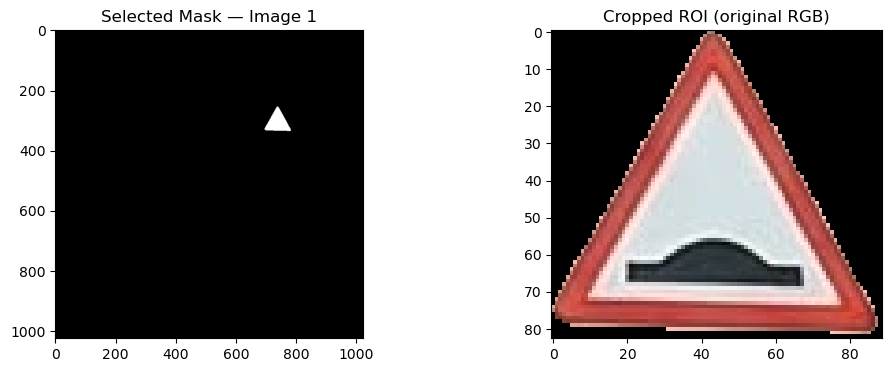


 IMAGE 2 — Step 4 Shape Filtering
Total components found: 1


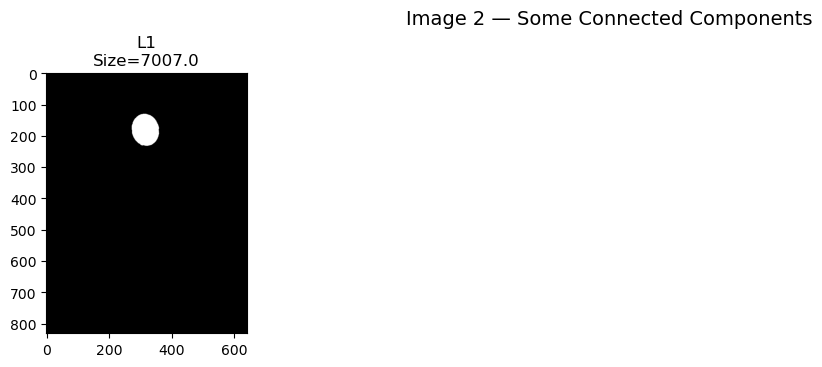


Component 1:
  Size        = 7007.0
  Area        = 7007.0
  Perimeter   = 319.04877323527904
  Circularity = 0.865
  → accepted (circle)

SELECTED COMPONENT:
  Size   = 7007.0
  BBox   = (133, 273, 235, 360)



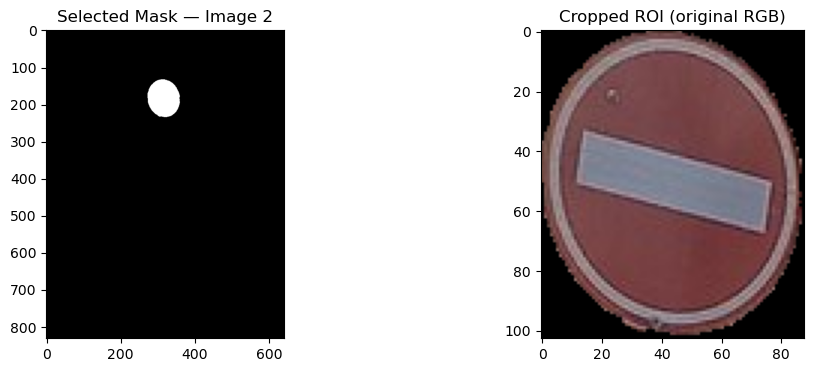


 IMAGE 3 — Step 4 Shape Filtering
Total components found: 1


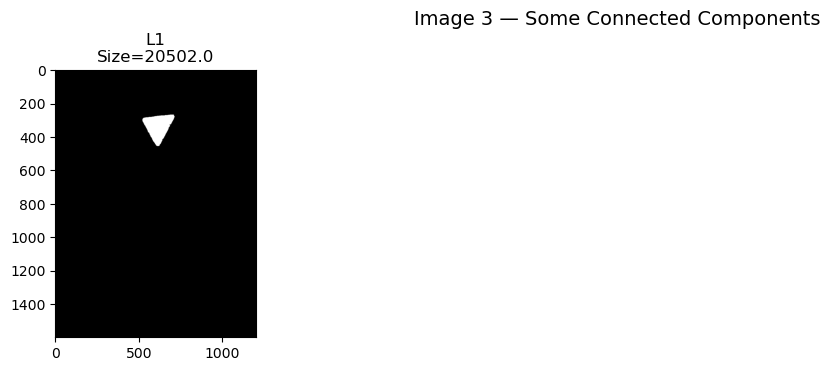


Component 1:
  Size        = 20502.0
  Area        = 20502.0
  Perimeter   = 655.3279938488577
  Circularity = 0.600
  → accepted (triangle)

SELECTED COMPONENT:
  Size   = 20502.0
  BBox   = (272, 522, 460, 714)



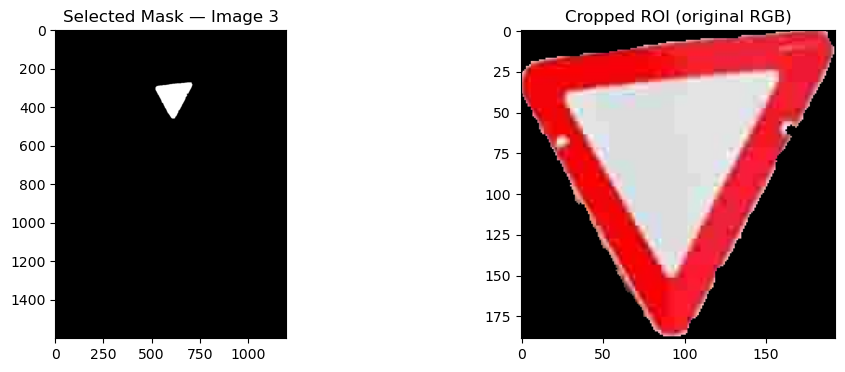


 IMAGE 4 — Step 4 Shape Filtering
Total components found: 2


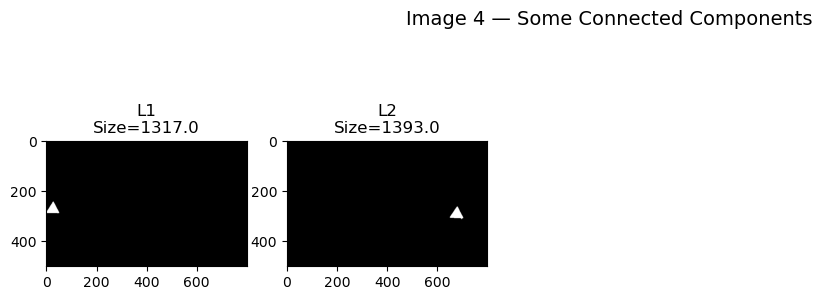


Component 1:
  Size        = 1317.0
  Area        = 1317.0
  Perimeter   = 164.36753236814712
  Circularity = 0.613
  → accepted (triangle)

Component 2:
  Size        = 1393.0
  Area        = 1393.0
  Perimeter   = 169.23149339882607
  Circularity = 0.611
  → accepted (triangle)

SELECTED COMPONENT:
  Size   = 1393.0
  BBox   = (264, 648, 315, 702)



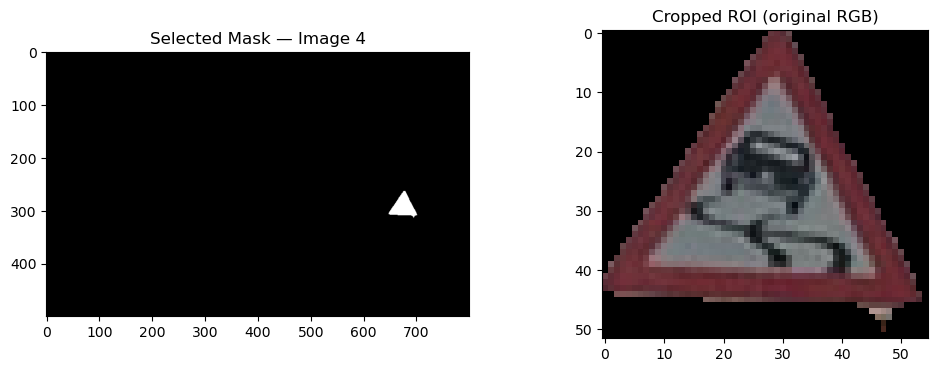


 IMAGE 5 — Step 4 Shape Filtering
Total components found: 3


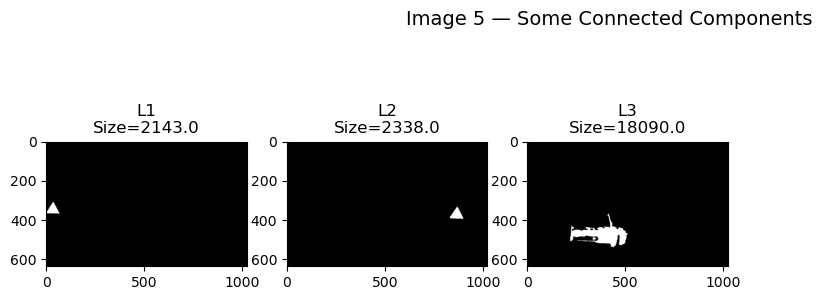


Component 1:
  Size        = 2143.0
  Area        = 2143.0
  Perimeter   = 215.48023074035524
  Circularity = 0.580
  → accepted (triangle)

Component 2:
  Size        = 2338.0
  Area        = 2338.0
  Perimeter   = 217.65180361560903
  Circularity = 0.620
  → accepted (triangle)

Component 3:
  Size        = 18090.0
  Area        = 18090.0
  Perimeter   = 1554.6265504461921
  Circularity = 0.094
  → rejected

SELECTED COMPONENT:
  Size   = 2338.0
  BBox   = (335, 829, 397, 899)



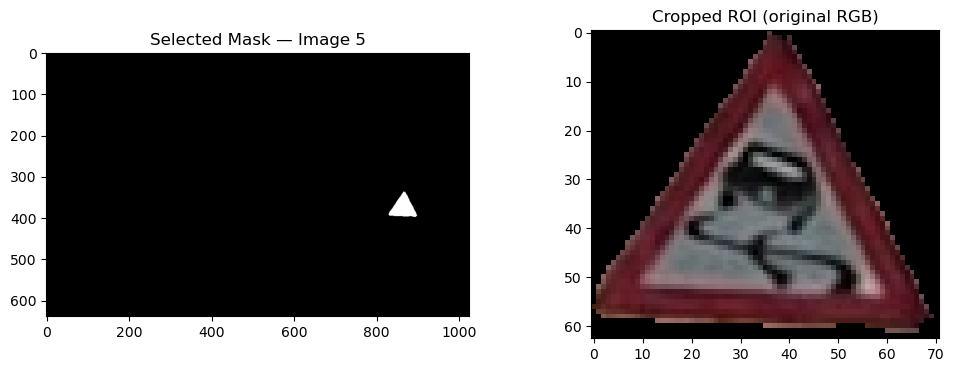

In [68]:
from skimage import measure
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------
# STEP 4 — Shape Filtering + Debug Visualization (uses precomputed props/labels)
# -----------------------------------------------------------

circle_threshold = 0.7  
triangle_threshold = 0.55   

step4_components = []  # final chosen component per image

for img_id, mask in enumerate(fixed_masks, start=1):

    print("\n============================================")
    print(f" IMAGE {img_id} — Step 4 Shape Filtering")
    print("============================================")
    labels = fixed_labels_list[img_id - 1]
    props  = fixed_props_list[img_id - 1]


    num_labels = len(props)
    print(f"Total components found: {num_labels}")

    comps = []
    for p in props:
        label = p.label
        size = p.area
        bbox = p.bbox
        area = p.area
        per = getattr(p, 'perimeter', None)
        cmask = (labels == label).astype(np.uint8)
        comps.append((label, size, cmask, bbox, area, per))

    # --- Visualize first components ---
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"Image {img_id} — Some Connected Components", fontsize=14)
    for idx, (label, size, cmask, bbox, area, per) in enumerate(comps[:5]):
        plt.subplot(1, 5, idx+1)
        plt.imshow(cmask, cmap='gray')
        plt.title(f"L{label}\nSize={size}")
    plt.show()

    # --- Evaluate components ---
    valid = []
    for label, size, cmask, bbox, area, per in comps:
        if per is None:
            # fallback perimeter
            per = 0
            H, W = cmask.shape
            for r in range(H):
                for c in range(W):
                    if cmask[r,c] == 1:
                        if (r == 0 or cmask[r-1,c] == 0 or
                            r == H-1 or cmask[r+1,c] == 0 or
                            c == 0 or cmask[r,c-1] == 0 or
                            c == W-1 or cmask[r,c+1] == 0):
                            per += 1

        circ = (4 * np.pi * area) / (per * per) if per > 0 else 0

        print(f"\nComponent {label}:")
        print(f"  Size        = {size}")
        print(f"  Area        = {area}")
        print(f"  Perimeter   = {per}")
        print(f"  Circularity = {circ:.3f}")

        if area < 300:
            print("  → rejected (too small)")
            continue

        if triangle_threshold < circ <= circle_threshold:
            print("  → accepted (triangle)")
            valid.append((size, cmask, bbox))
            continue

        if circ > circle_threshold:
            print("  → accepted (circle)")
            valid.append((size, cmask, bbox))
            continue

        print("  → rejected")


    if len(valid) == 0:
        print("\nNO VALID SIGN FOUND in this image.\n")
        step4_components.append((None, None))
        continue

    # --- Pick largest valid component ---
    best = max(valid, key=lambda x: x[0])
    best_size, best_mask, best_bbox = best

    print("\nSELECTED COMPONENT:")
    print(f"  Size   = {best_size}")
    print(f"  BBox   = {best_bbox}\n")

    # --- Extract ROI from original RGB image ---
    ymin, xmin, ymax, xmax = best_bbox
    orig = images[img_id - 1] 
    mask3 = best_mask.astype(orig.dtype)[..., None]
    masked_orig = orig * mask3
    crop = masked_orig[ymin:ymax+1, xmin:xmax+1]

    # --- Visualize selected mask + cropped ROI ---
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.imshow(best_mask, cmap='gray')
    plt.title(f"Selected Mask — Image {img_id}")

    plt.subplot(1,2,2)
    plt.imshow(crop)
    plt.title("Cropped ROI (original RGB)")

    plt.show()

    step4_components.append((best_mask, best_bbox))


# Step 3 - Resize ROI


--------------------------------------------
 IMAGE 1 — Step 5: ROI Resize
--------------------------------------------
  Original crop shape: (83, 89, 3)
  Resized crop shape: (64, 64, 3)


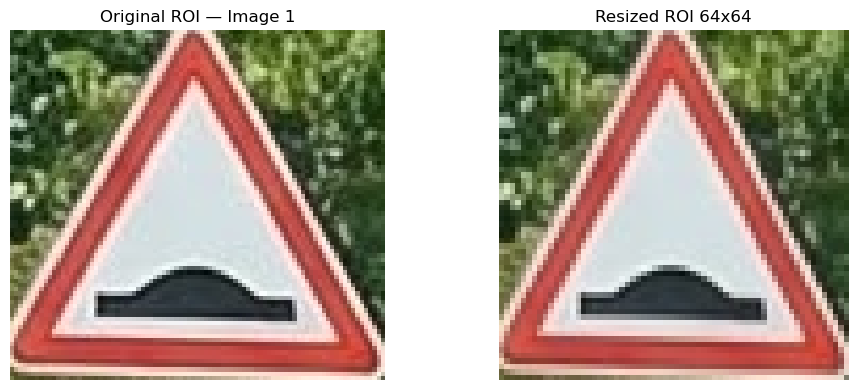


--------------------------------------------
 IMAGE 2 — Step 5: ROI Resize
--------------------------------------------
  Original crop shape: (103, 88, 3)
  Resized crop shape: (64, 64, 3)


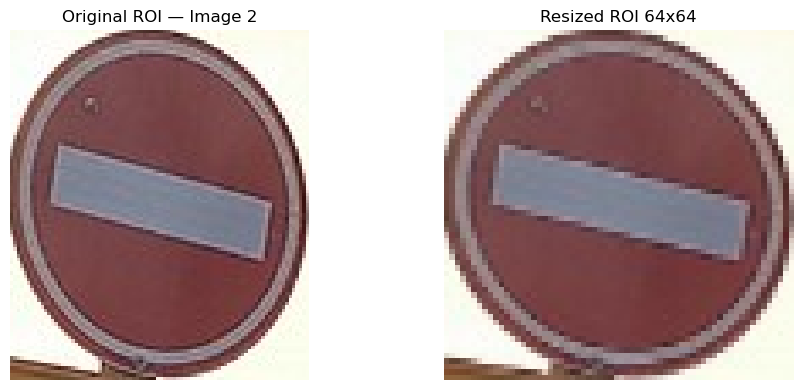


--------------------------------------------
 IMAGE 3 — Step 5: ROI Resize
--------------------------------------------
  Original crop shape: (189, 193, 3)
  Resized crop shape: (64, 64, 3)


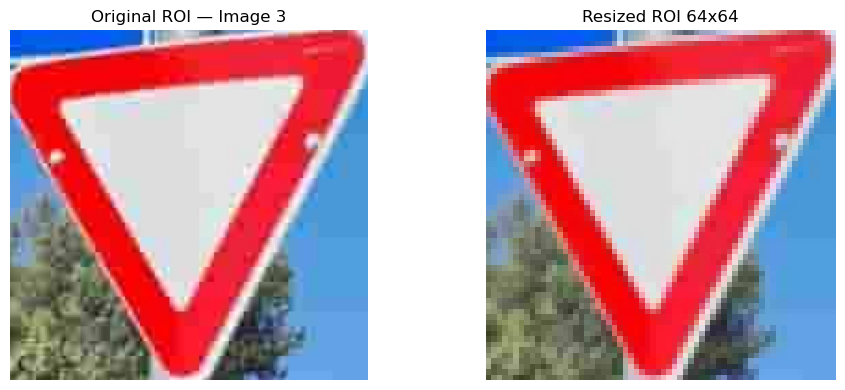


--------------------------------------------
 IMAGE 4 — Step 5: ROI Resize
--------------------------------------------
  Original crop shape: (52, 55, 3)
  Resized crop shape: (64, 64, 3)


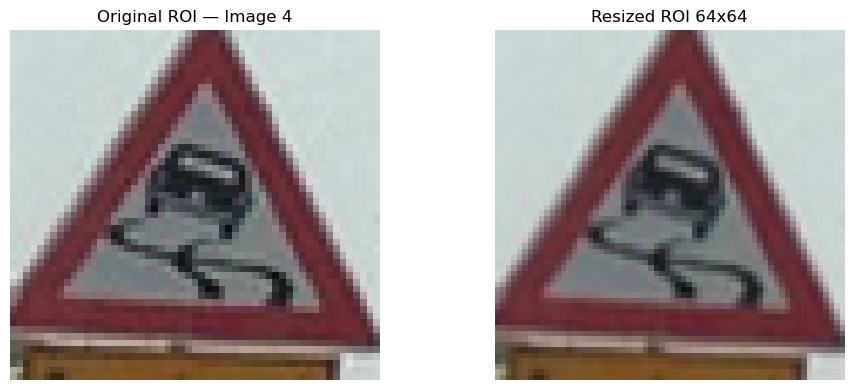


--------------------------------------------
 IMAGE 5 — Step 5: ROI Resize
--------------------------------------------
  Original crop shape: (63, 71, 3)
  Resized crop shape: (64, 64, 3)


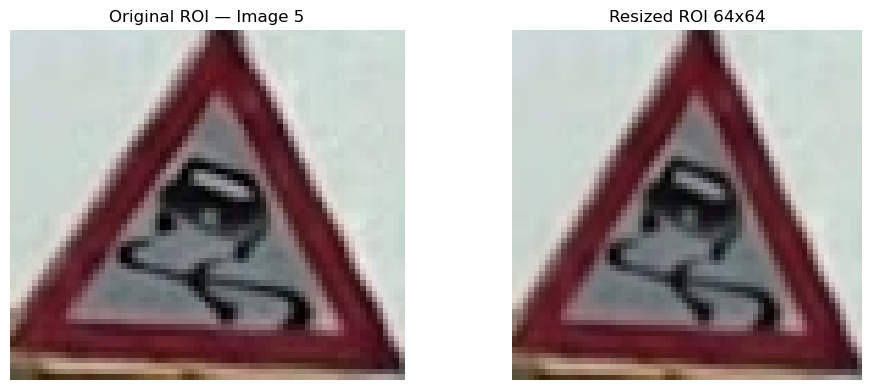

In [69]:
# -----------------------------------------------------------
# STEP 5 — Resize ROI to a fixed size (for template matching)
# -----------------------------------------------------------

from skimage import transform

TARGET_H = 64   # target height (can be changed)
TARGET_W = 64   # target width  (can be changed)

resized_rois = []   # will store the resized RGB patches (or None if no sign)

for img_id, (mask, bbox) in enumerate(step4_components, start=1):

    print("\n--------------------------------------------")
    print(f" IMAGE {img_id} — Step 5: ROI Resize")
    print("--------------------------------------------")

    # If no valid component was found in this image
    if mask is None or bbox is None:
        print("No valid sign for this image → skipping resize.")
        resized_rois.append(None)
        continue

    # Unpack bbox from regionprops:
    # regionprops.bbox = (min_row, min_col, max_row, max_col)
    ymin, xmin, ymax, xmax = bbox

    # Safety clamp (in case bbox is slightly out of bounds)
    orig = images[img_id - 1]
    H, W = orig.shape[:2]
    ymin = max(0, ymin)
    xmin = max(0, xmin)
    ymax = min(H - 1, ymax)
    xmax = min(W - 1, xmax)

    # Crop ROI from original RGB image
    crop = orig[ymin:ymax+1, xmin:xmax+1]

    print(f"  Original crop shape: {crop.shape}")

    # Resize to fixed size.
    # preserve_range=True → keep 0–255 range, then cast to uint8
    crop_resized = transform.resize(
        crop,
        (TARGET_H, TARGET_W),
        anti_aliasing=True,
        preserve_range=True
    ).astype(np.uint8)

    print(f"  Resized crop shape: {crop_resized.shape}")

    resized_rois.append(crop_resized)

    # Visualization: original crop vs resized crop
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(crop)
    plt.title(f"Original ROI — Image {img_id}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(crop_resized)
    plt.title(f"Resized ROI {TARGET_W}x{TARGET_H}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Step 4 - Template Matching

Loaded templates: ['rsz_123-1', 'rsz_126-1', 'rsz_136-1', 'rsz_141', 'rsz_144-1', 'rsz_1s_30', 'rsz_301_optimized', 'rsz_302_optimized', 'rsz_402_optimized', 'rsz_s_40']
Image 1: best='rsz_301_optimized' score=0.107 => pred='unknown'
Image 2: best='rsz_402_optimized' score=0.683 => pred='rsz_402_optimized'
Image 3: best='rsz_301_optimized' score=0.445 => pred='rsz_301_optimized'
Image 4: best='rsz_141' score=0.517 => pred='rsz_141'
Image 5: best='rsz_123-1' score=0.654 => pred='rsz_123-1'


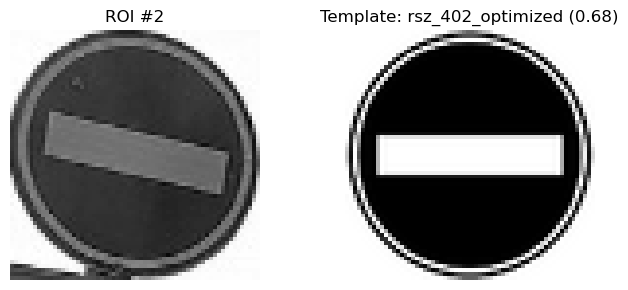

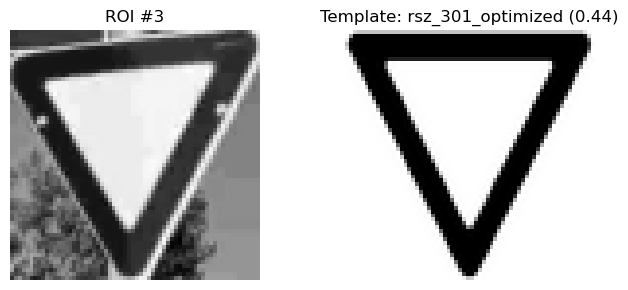

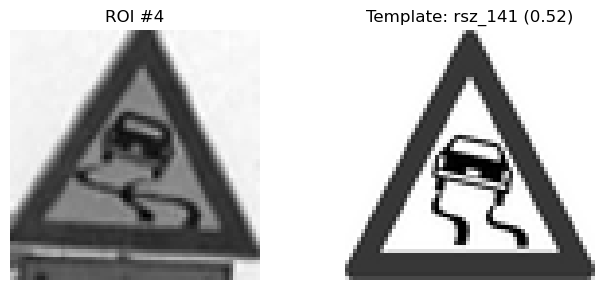

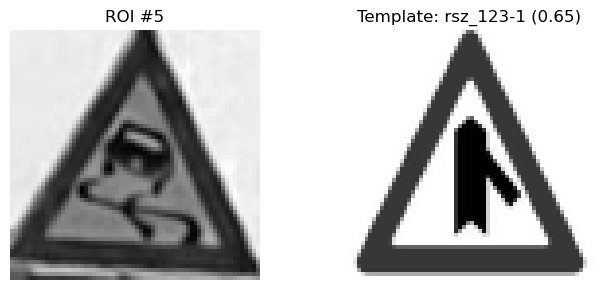

In [70]:
# -----------------------------------------------------------
# STEP 6 — BASIC Template Matching (same-size) + Decision
# -----------------------------------------------------------

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform

TEMPLATE_DIR = "Templates"
TARGET_H, TARGET_W = 64, 64

# --------------- basic helpers ---------------
def to_gray01(img):
    """Convert RGB/Gray image to grayscale float32 in [0,1]."""
    if img is None:
        return None
    g = color.rgb2gray(img) if img.ndim == 3 else img.astype(np.float32)
    g = g.astype(np.float32)
    if g.max() > 1.0:
        g /= 255.0
    return np.clip(g, 0.0, 1.0)

def resize_to_target(img, h=TARGET_H, w=TARGET_W):
    """Resize image to (h,w) as float32 in [0,1]."""
    g = to_gray01(img)
    if g is None:
        return None
    if g.shape != (h, w):
        g = transform.resize(g, (h, w), anti_aliasing=True, preserve_range=True).astype(np.float32)
    return g

def zncc(a, b, eps=1e-8):
    """
    Zero-mean Normalized Cross-Correlation for same-size arrays.
    Score in [-1,1], higher is better.
    """
    a = a.astype(np.float32); b = b.astype(np.float32)
    a = a - a.mean()
    b = b - b.mean()
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + eps
    return float((a * b).sum() / denom)

# --------------- load templates ---------------
if not os.path.isdir(TEMPLATE_DIR):
    raise FileNotFoundError(f"Folder '{TEMPLATE_DIR}' not found. Create it next to the notebook.")

templates = {}  # label -> 2D float32 (TARGET_H,TARGET_W)
valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")

for fname in sorted(os.listdir(TEMPLATE_DIR)):
    if not fname.lower().endswith(valid_ext):
        continue
    label = os.path.splitext(fname)[0]  # filename without extension
    img = io.imread(os.path.join(TEMPLATE_DIR, fname))
    templates[label] = resize_to_target(img)

if len(templates) == 0:
    raise RuntimeError(f"No template images found in '{TEMPLATE_DIR}' (png/jpg/etc).")

print("Loaded templates:", list(templates.keys()))

# --------------- match each ROI ---------------
MATCH_THRESHOLD = 0.35  # start here; tune later if needed

pred_labels = []
best_scores = []

for i, roi_rgb in enumerate(resized_rois, start=1):
    if roi_rgb is None:
        pred_labels.append("no_sign")
        best_scores.append(None)
        continue

    roi = resize_to_target(roi_rgb)  # 2D float

    scores = {}
    for lab, tmpl in templates.items():
        scores[lab] = zncc(roi, tmpl)

    best_lab = max(scores, key=scores.get)
    best_sc  = scores[best_lab]

    pred = best_lab if best_sc >= MATCH_THRESHOLD else "unknown"
    pred_labels.append(pred)
    best_scores.append(best_sc)

    print(f"Image {i}: best='{best_lab}' score={best_sc:.3f} => pred='{pred}'")

# --------------- optional quick visualization ---------------
# Show ROI vs chosen template for first few images
show_n = min(6, len(resized_rois))
for idx in range(show_n):
    if resized_rois[idx] is None or pred_labels[idx] in ("no_sign", "unknown"):
        continue

    roi = resize_to_target(resized_rois[idx])
    tmpl = templates[pred_labels[idx]]

    plt.figure(figsize=(7, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(roi, cmap="gray")
    plt.title(f"ROI #{idx+1}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tmpl, cmap="gray")
    plt.title(f"Template: {pred_labels[idx]} ({best_scores[idx]:.2f})")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
